In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")

#### Load and Explore the Dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

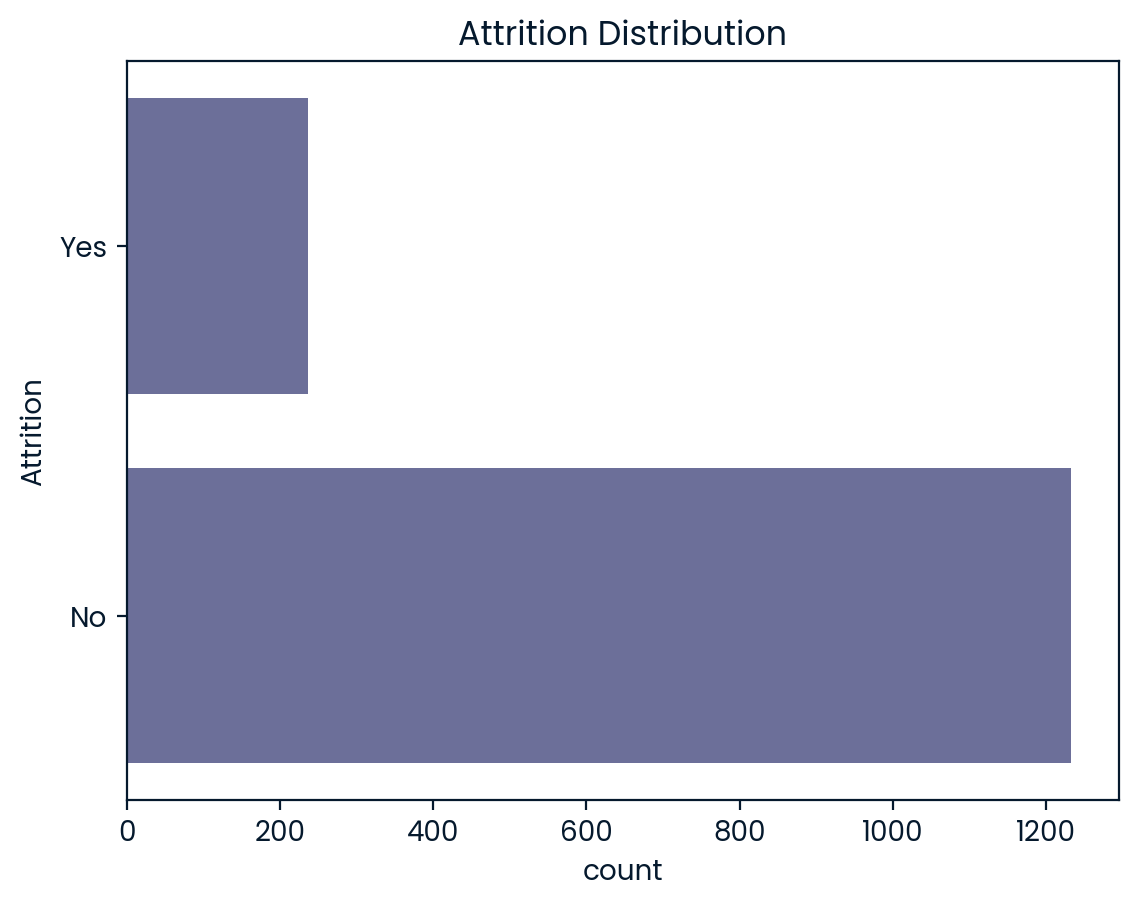

In [2]:
# Load the dataset
data = pd.read_csv('train.csv')

# Overview of the dataset
data.info()

# Display the first few rows
data.head()

# Check for missing values
data.isnull().sum()

# Check the target variable (Attrition)
print(data['Attrition'].value_counts(normalize=True))

# Visualize the target variable distribution
sns.countplot(data['Attrition'])
plt.title("Attrition Distribution")
plt.show()

####  Data Cleaning and Preprocessing

In [3]:
# Drop irrelevant columns (if any), e.g., 'EmployeeCount', 'Over18', 'StandardHours'
data = data.drop(['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeNumber'], axis=1)

# Encode the target variable
data['Attrition'] = data['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

# Label encoding for categorical variables
categorical_cols = data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# Check for imbalanced classes in Attrition
print(data['Attrition'].value_counts())

Attrition
0    1233
1     237
Name: count, dtype: int64


####  Exploratory Data Analysis (EDA)

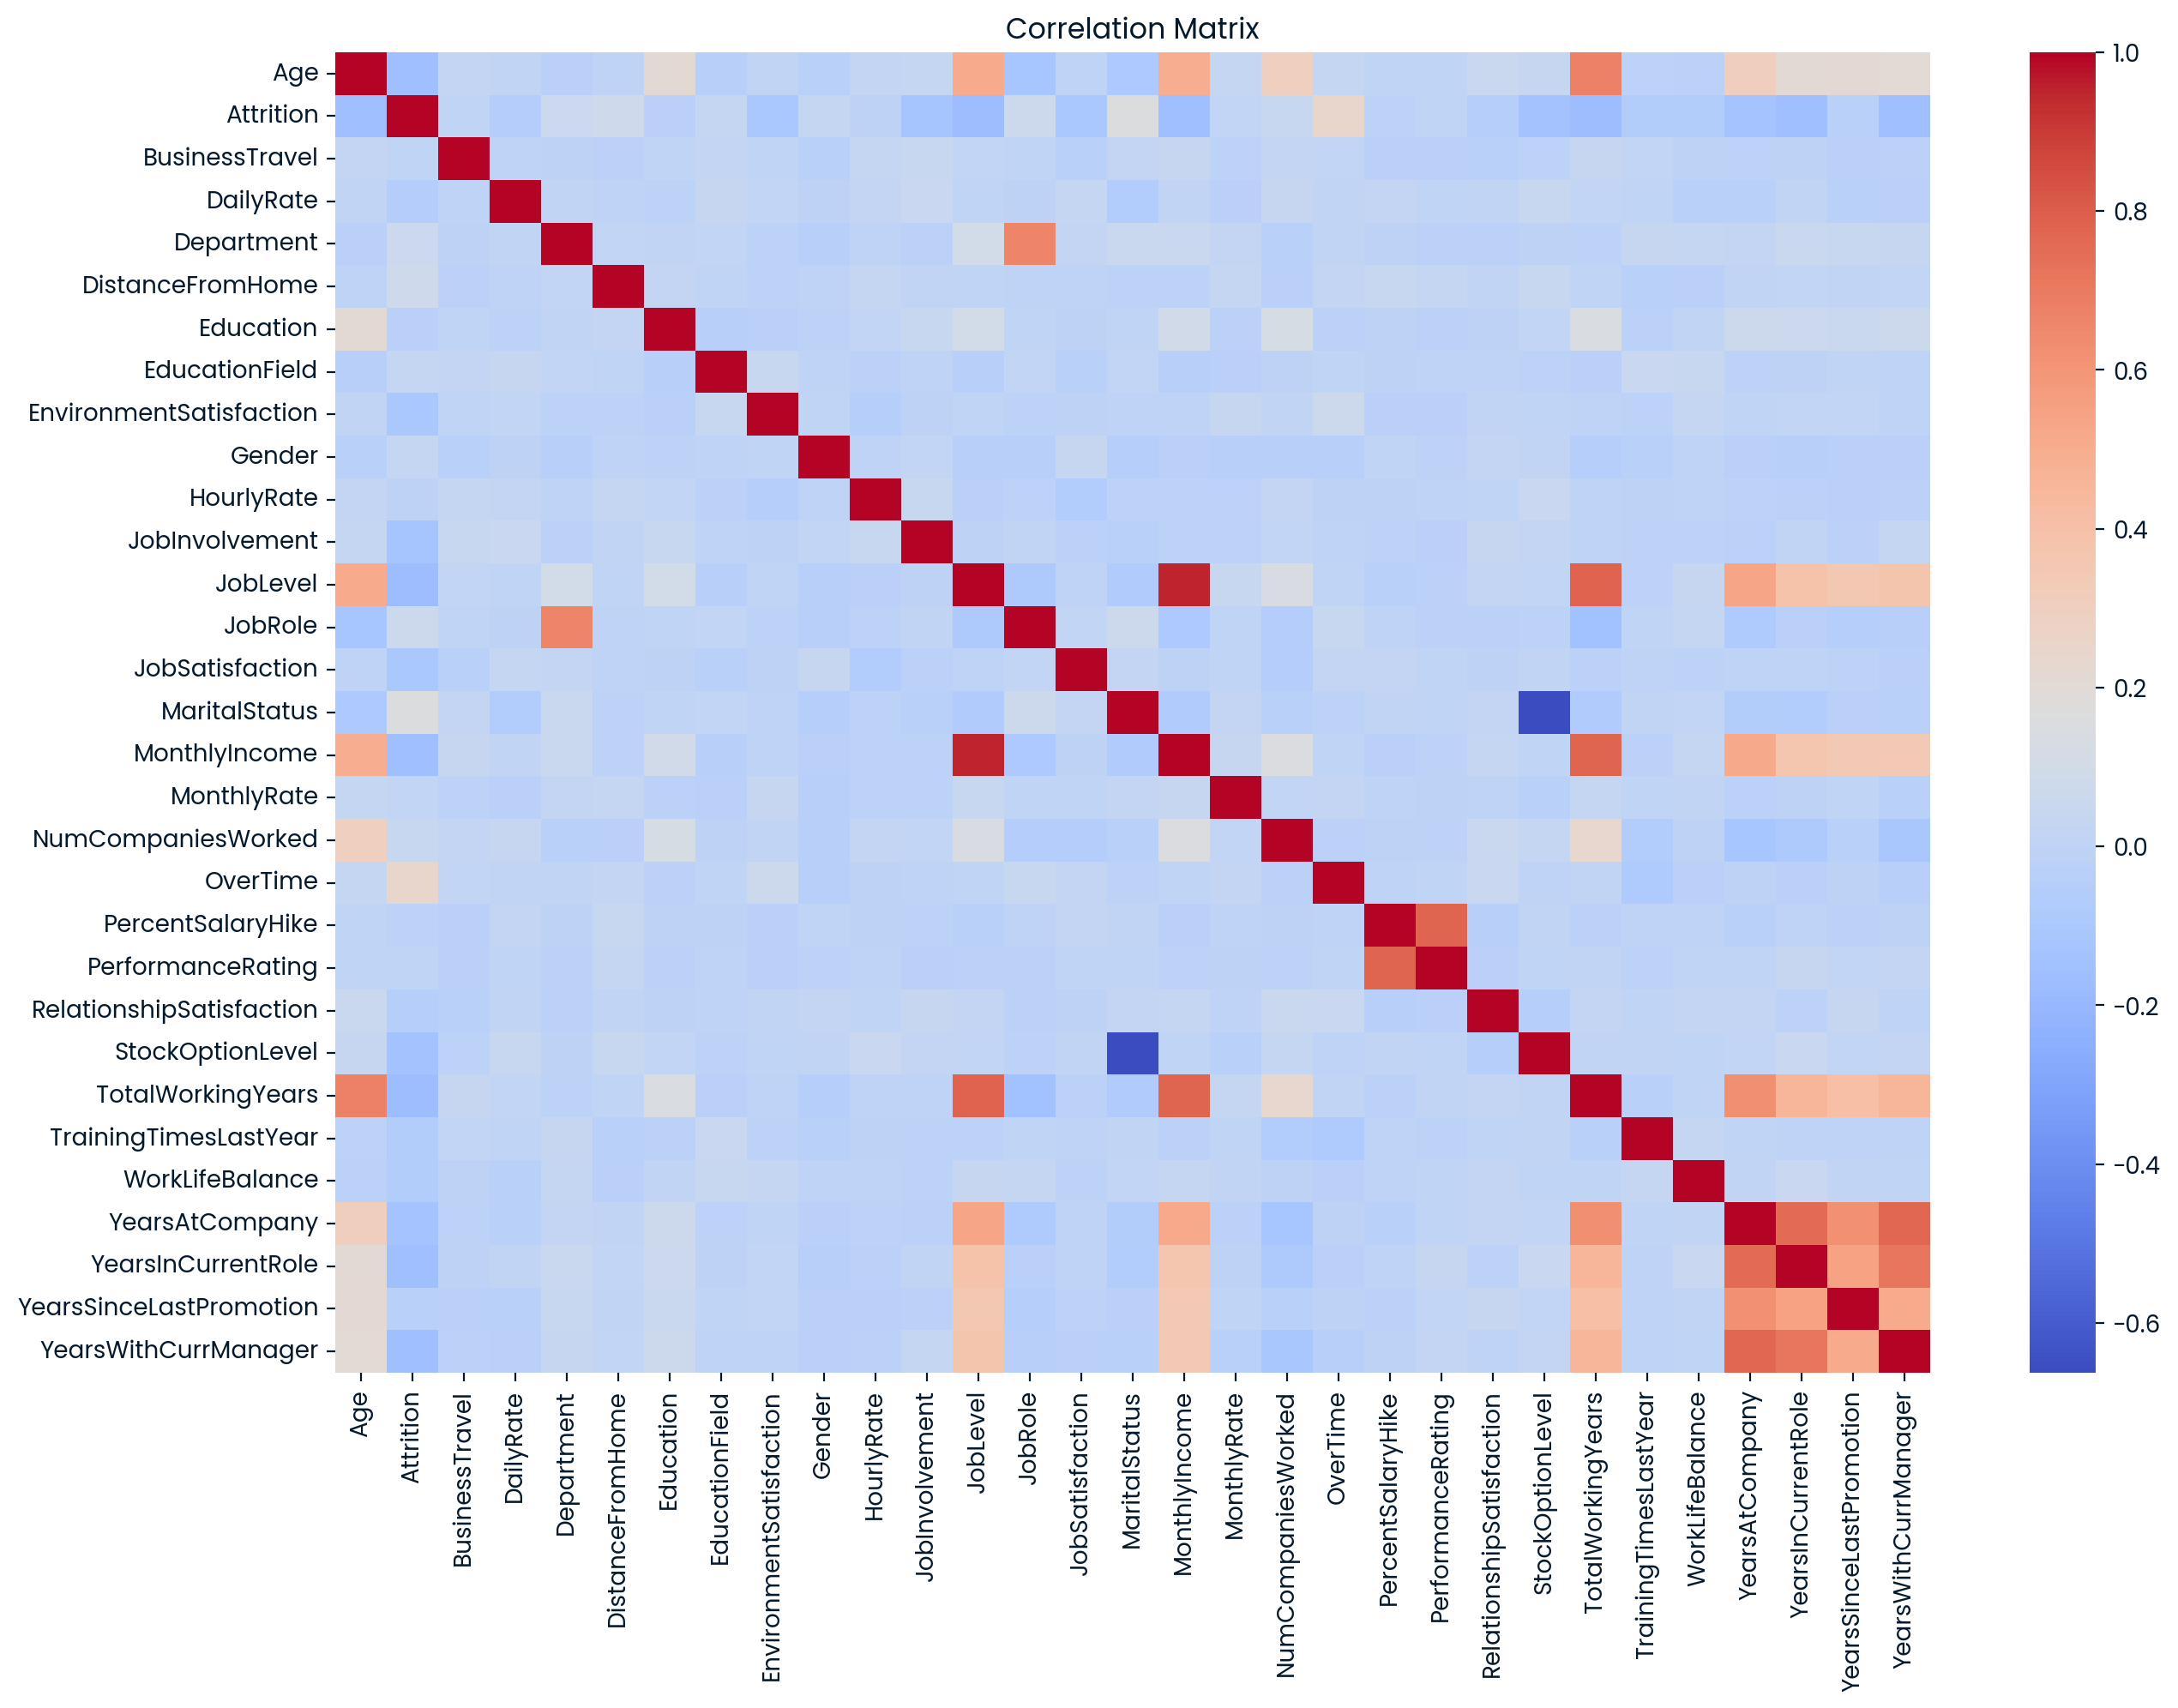

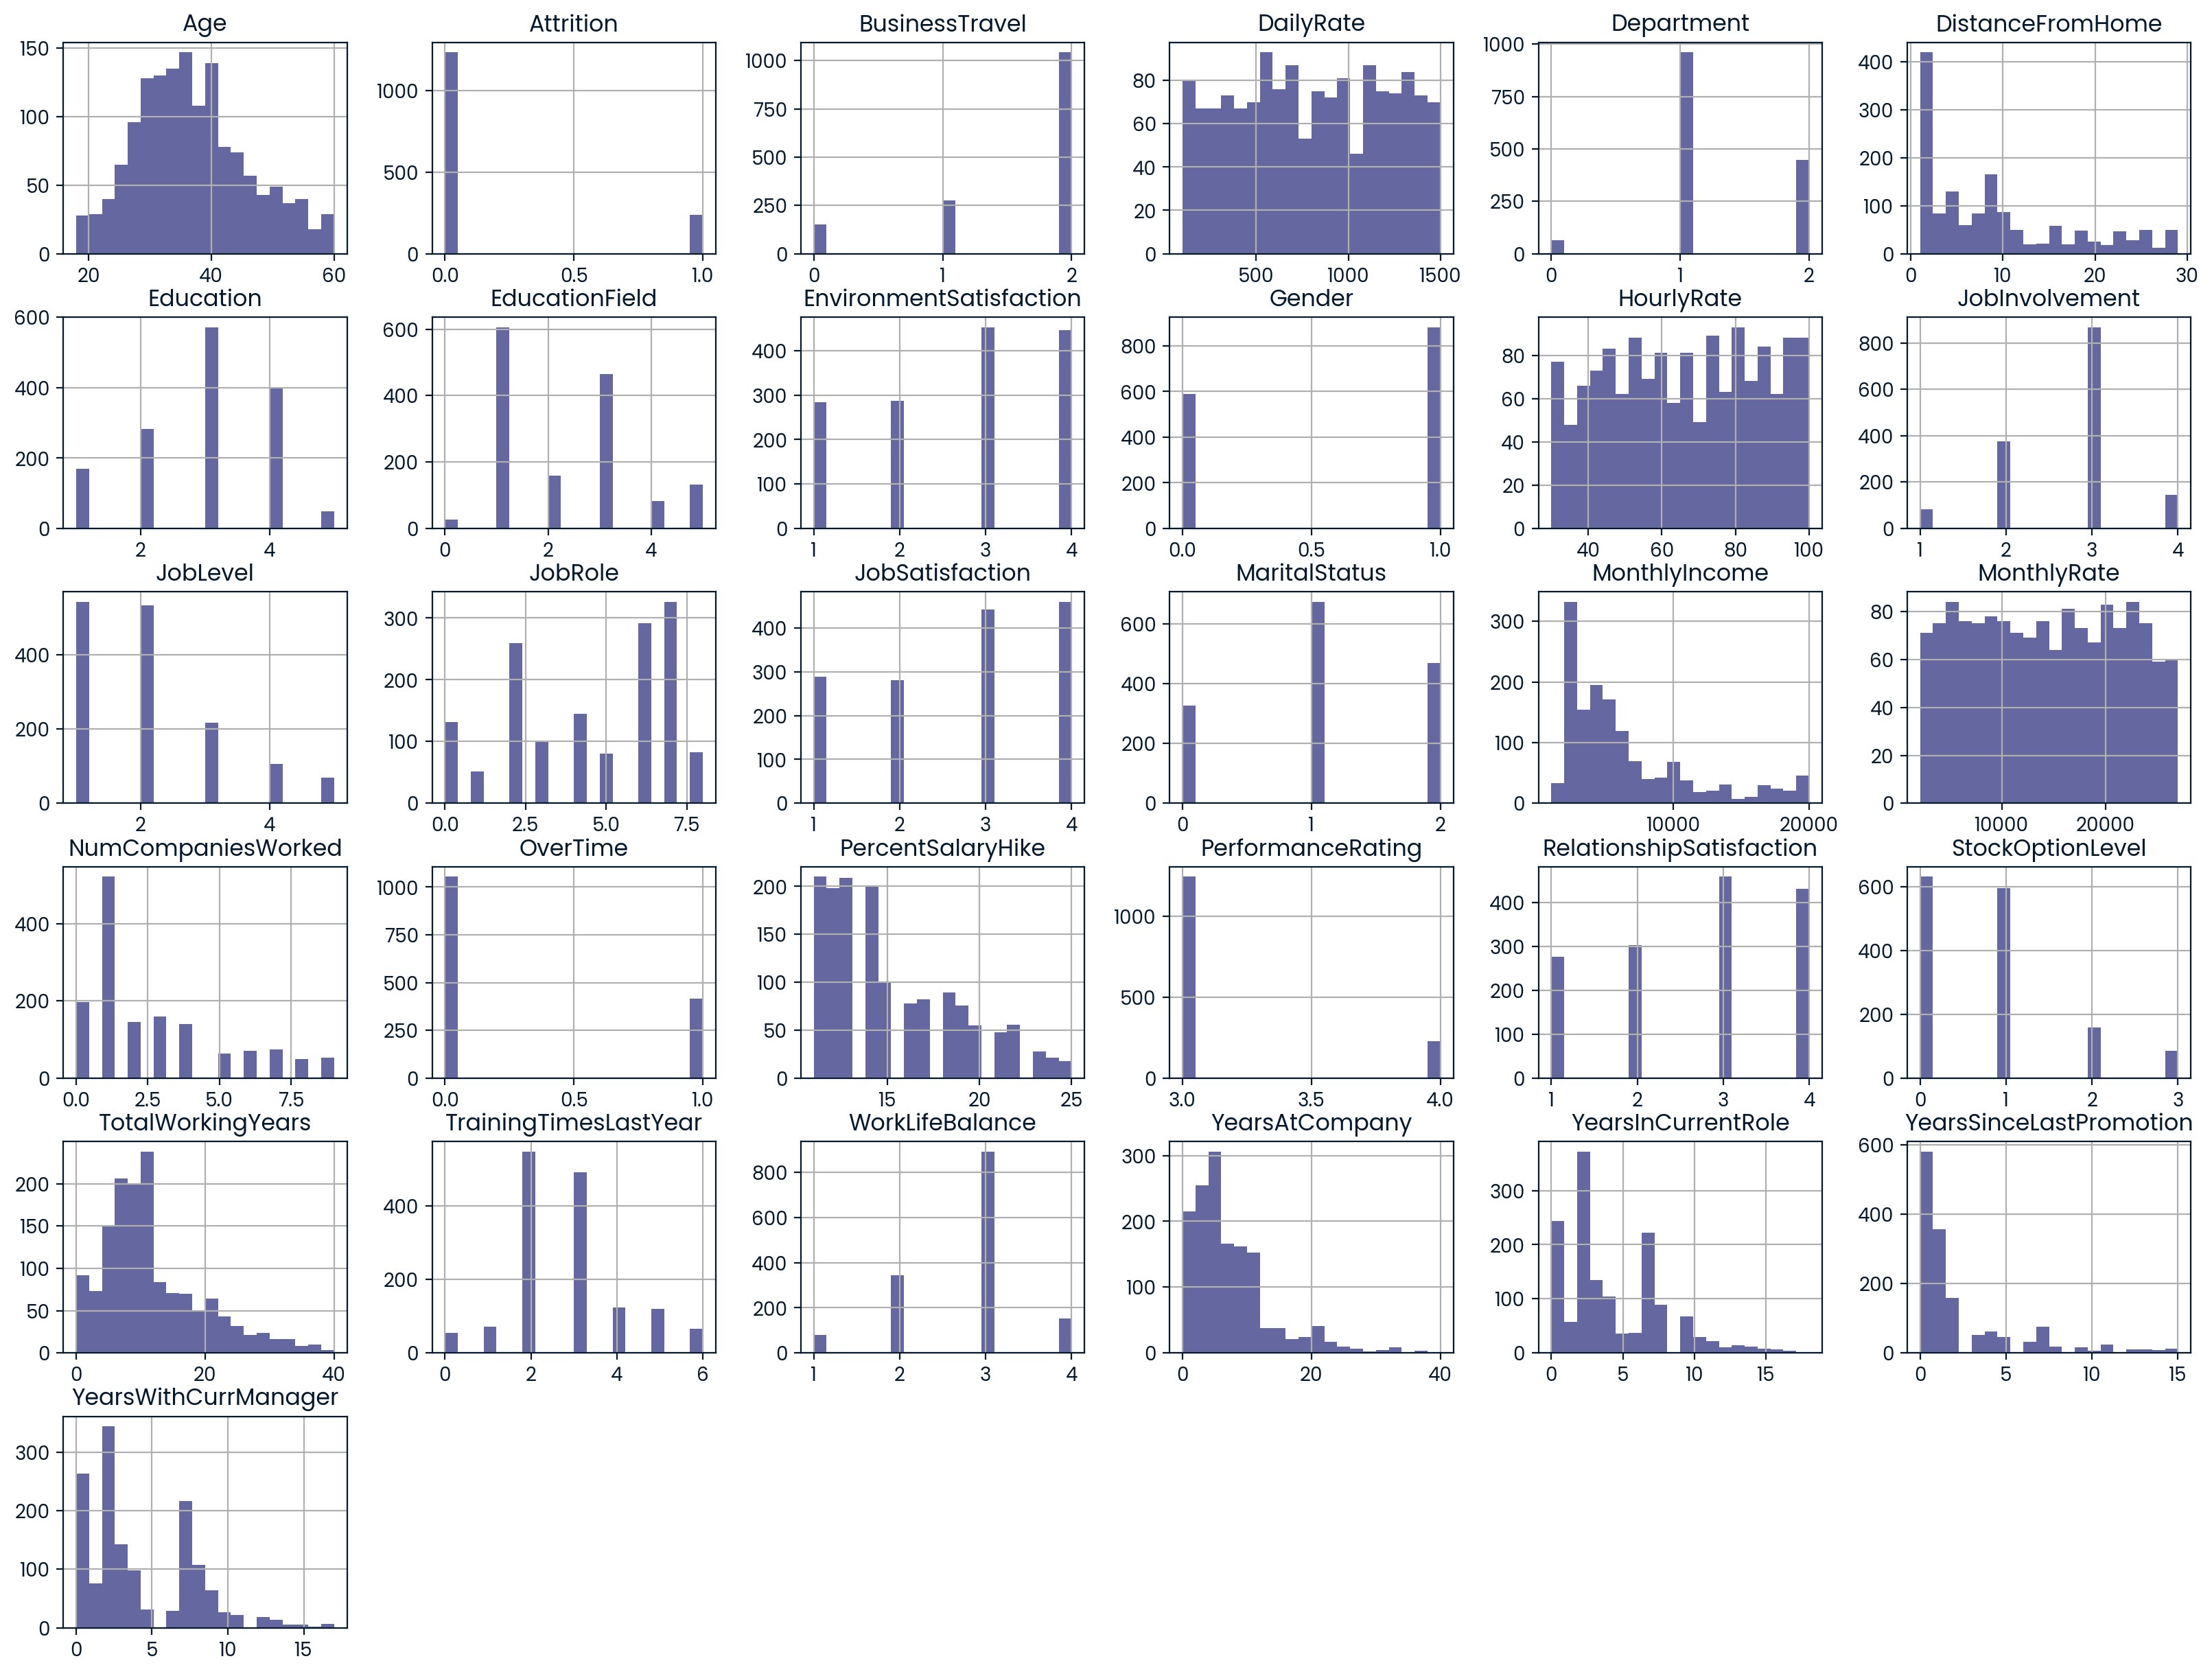

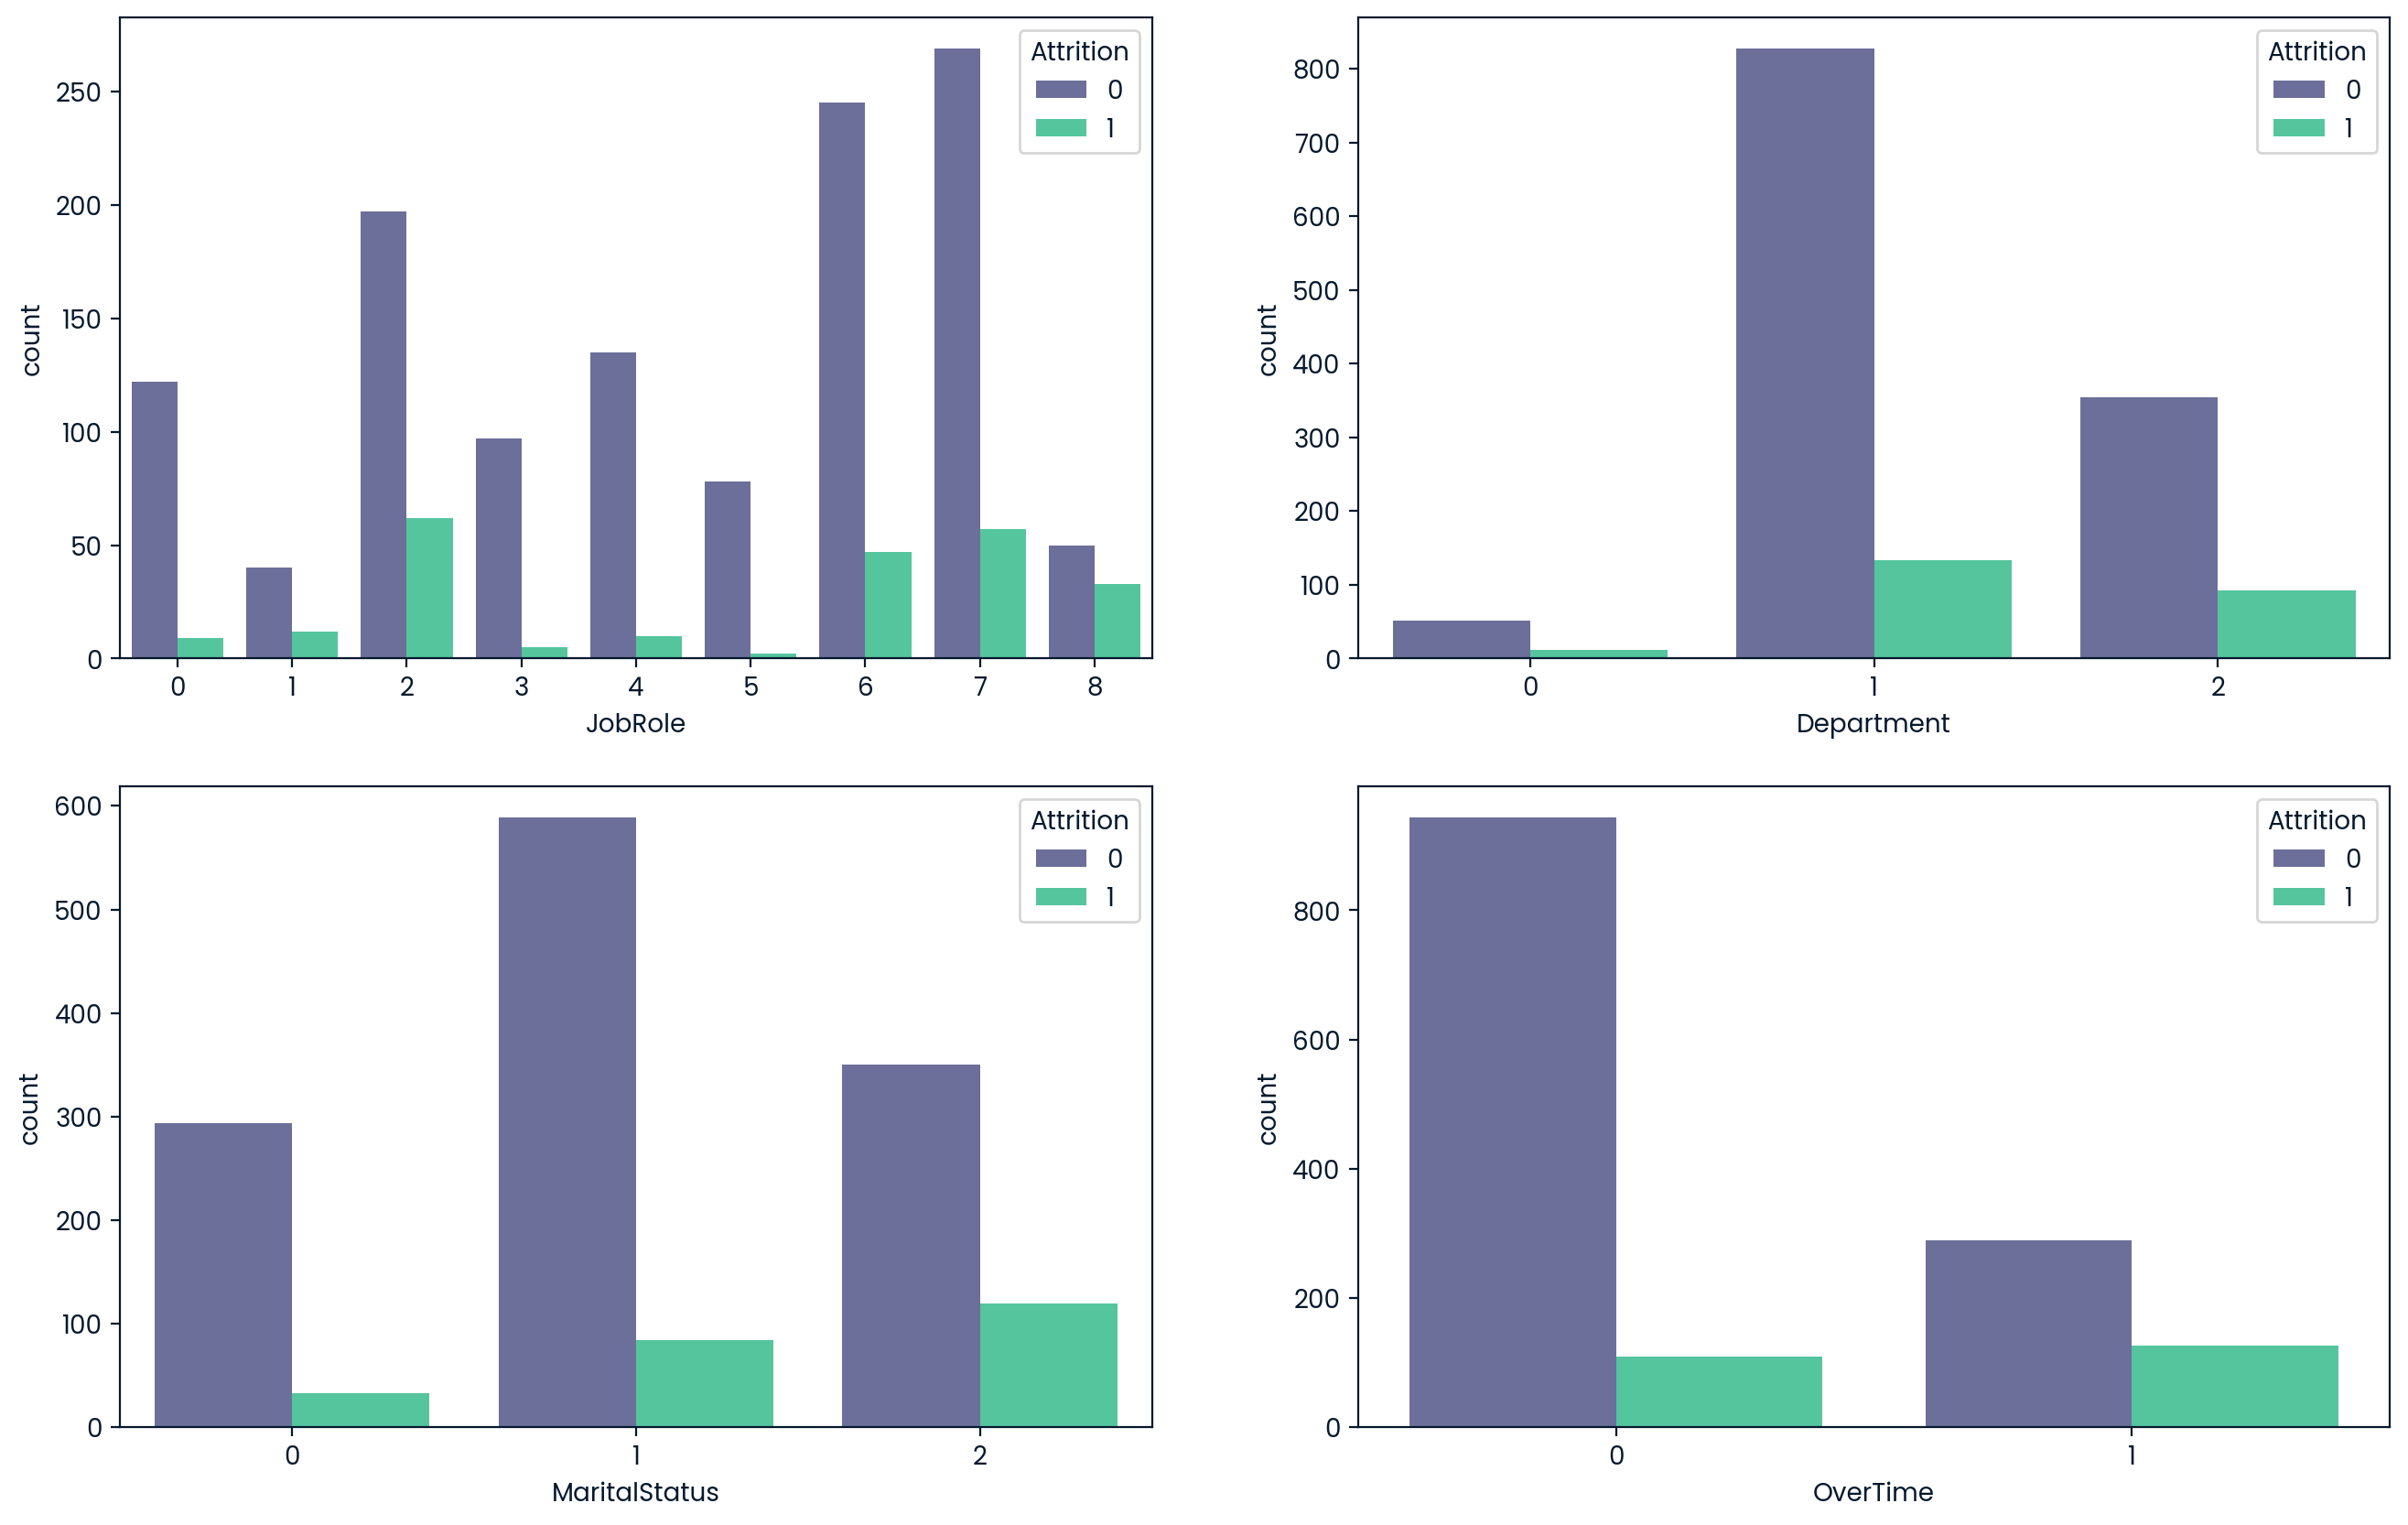

In [4]:
# Correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(data.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Distribution of numerical features
data.hist(bins=20, figsize=(20, 15))
plt.show()

# Attrition by various features
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
sns.countplot(x='JobRole', hue='Attrition', data=data, ax=axs[0, 0])
sns.countplot(x='Department', hue='Attrition', data=data, ax=axs[0, 1])
sns.countplot(x='MaritalStatus', hue='Attrition', data=data, ax=axs[1, 0])
sns.countplot(x='OverTime', hue='Attrition', data=data, ax=axs[1, 1])
plt.show()


#### Handle Class Imbalance with SMOTE

In [5]:
# Separate features and target
X = data.drop('Attrition', axis=1)
y = data['Attrition']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Balance the training set with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the new class distribution after SMOTE
print(pd.Series(y_train_smote).value_counts())


Attrition
0    853
1    853
Name: count, dtype: int64


#### Model Building (Logistic Regression, Random Forest, Gradient Boosting, XGBoost)

In [6]:
# Initialize models
log_reg = LogisticRegression()
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)

# Train models on the resampled dataset
models = {'Logistic Regression': log_reg, 'Random Forest': rf, 'Gradient Boosting': gb, 'XGBoost': xgb}
for name, model in models.items():
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test)
    print(f"---{name}---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"F1-Score: {f1_score(y_test, y_pred)}")
    print(f"Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}")
    print(f"Classification Report:\n {classification_report(y_test, y_pred)}")

---Logistic Regression---
Accuracy: 0.6757369614512472
F1-Score: 0.3157894736842105
Confusion Matrix:
 [[265 115]
 [ 28  33]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.70      0.79       380
           1       0.22      0.54      0.32        61

    accuracy                           0.68       441
   macro avg       0.56      0.62      0.55       441
weighted avg       0.81      0.68      0.72       441

---Random Forest---
Accuracy: 0.8458049886621315
F1-Score: 0.32
Confusion Matrix:
 [[357  23]
 [ 45  16]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.91       380
           1       0.41      0.26      0.32        61

    accuracy                           0.85       441
   macro avg       0.65      0.60      0.62       441
weighted avg       0.82      0.85      0.83       441

---Gradient Boosting---
Accuracy: 0.8458049886621315
F1-Score: 0.4

#### Model Evaluation and Tuning

In [7]:
# Perform hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

# Best parameters and evaluation
print(f"Best parameters: {grid_search.best_params_}")
y_pred_best = grid_search.predict(X_test)
print(f"Best Model F1-Score: {f1_score(y_test, y_pred_best)}")


Best parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Best Model F1-Score: 0.32


####  Model Interpretation using Feature Importance

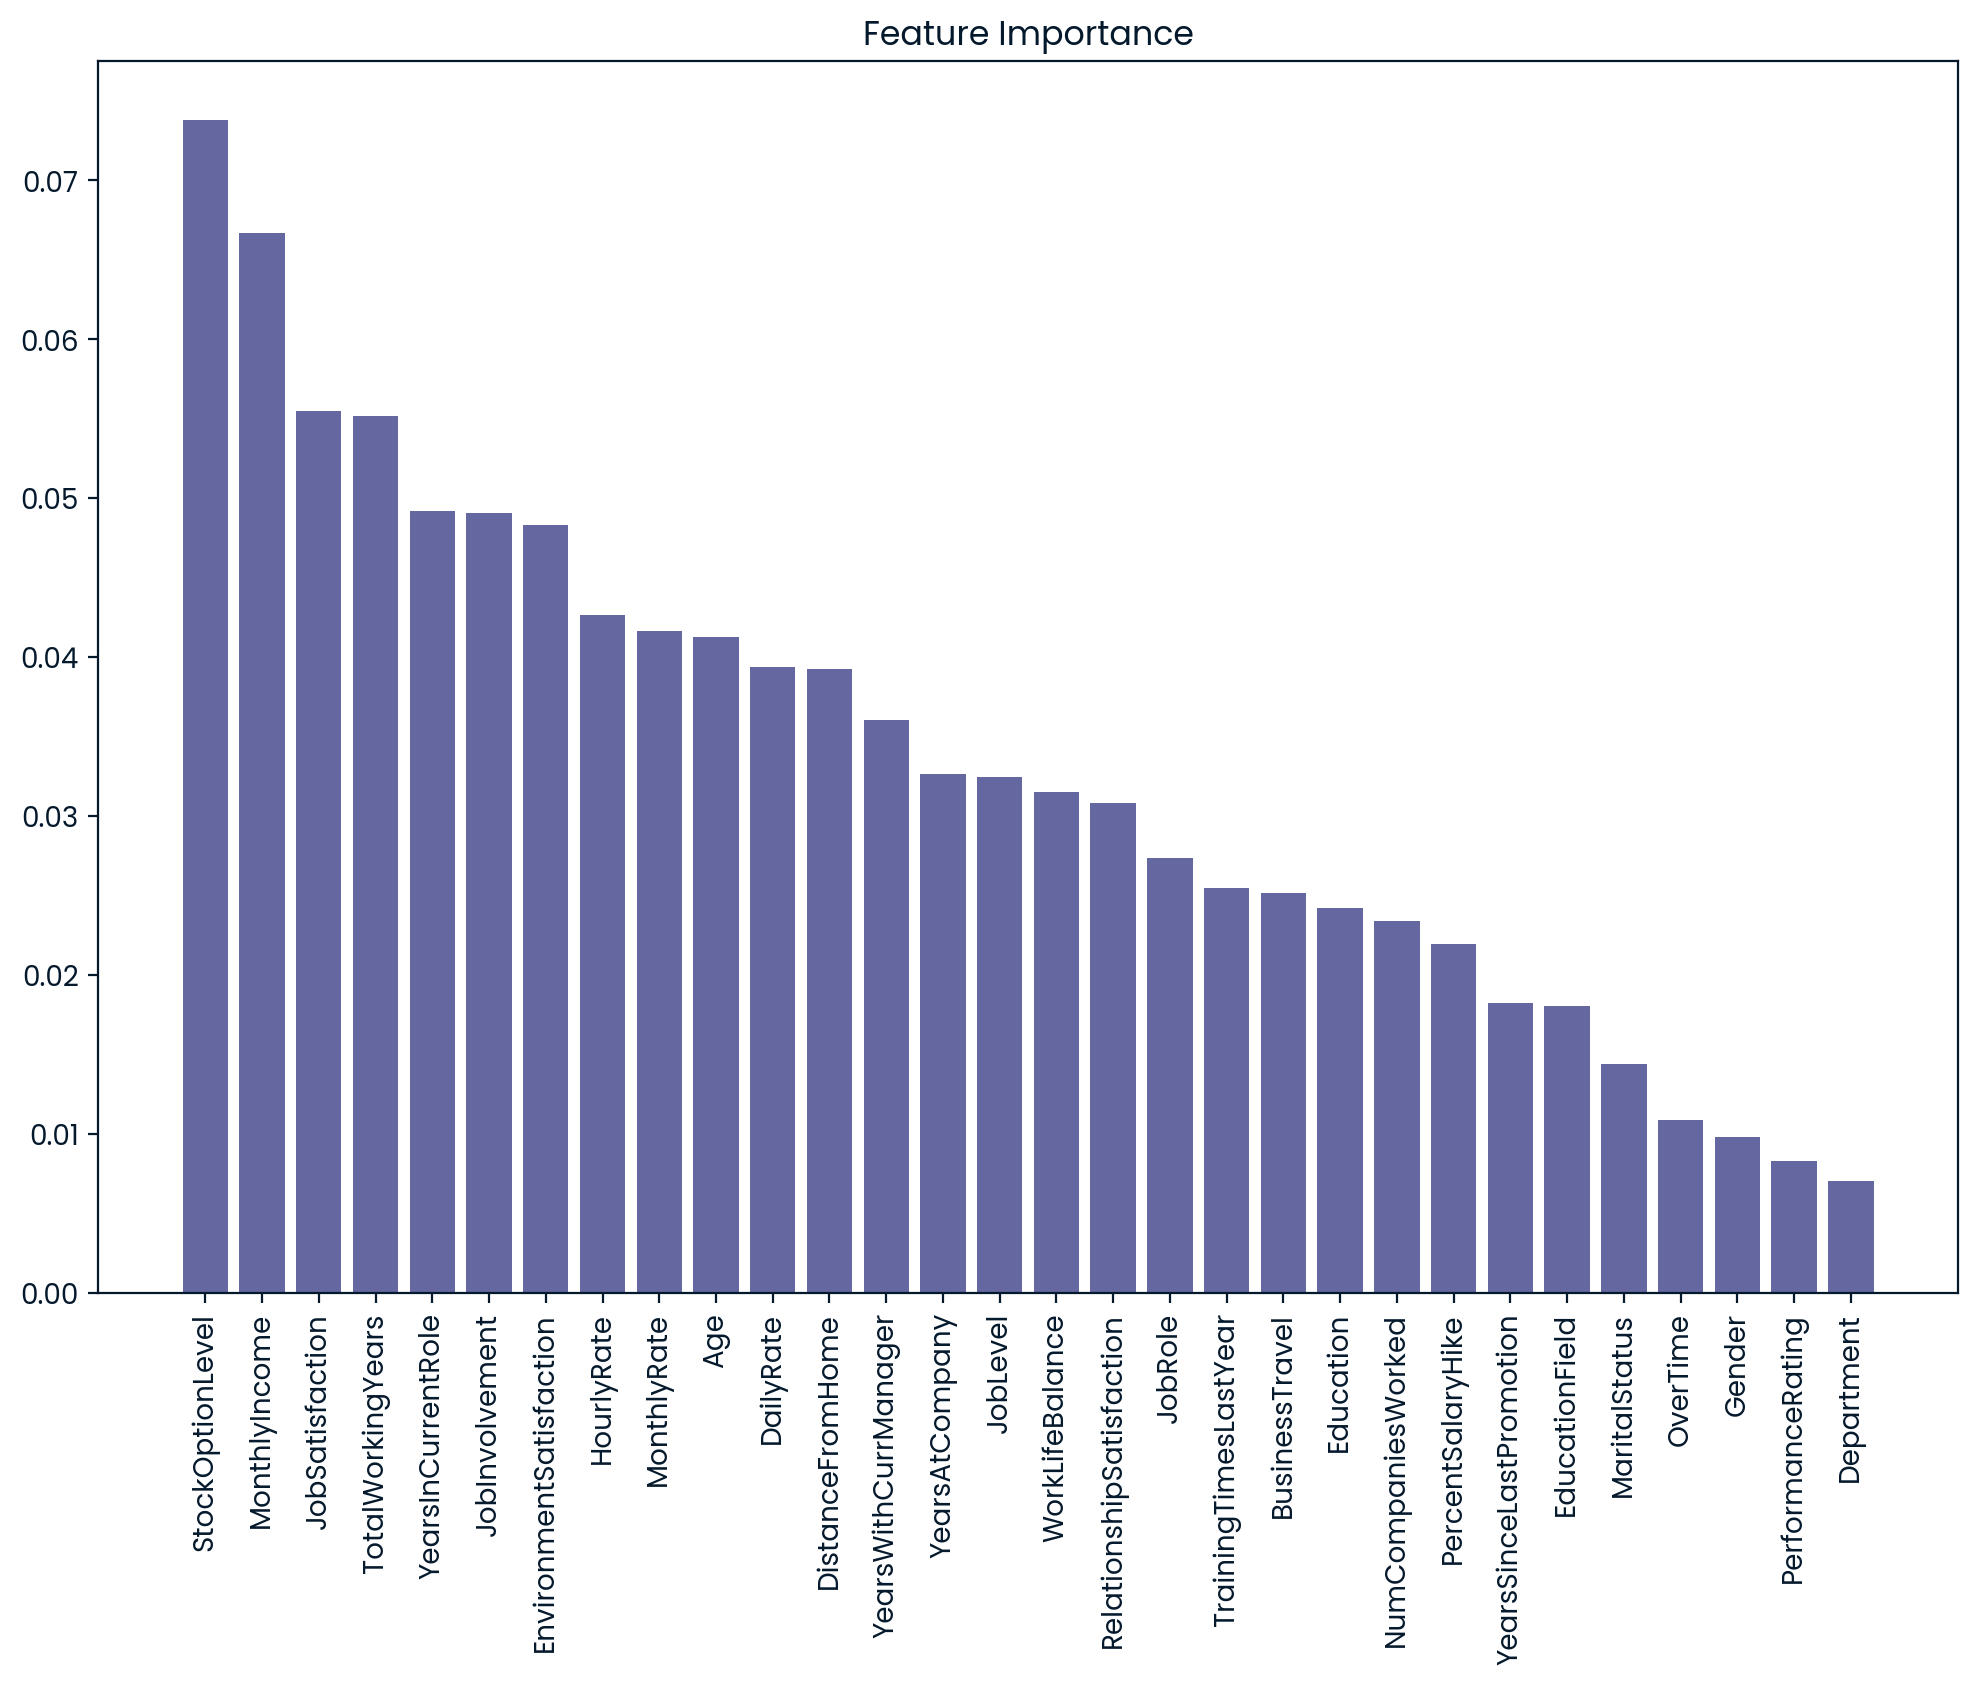

In [8]:
# Feature importance from Random Forest
importances = grid_search.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importance
plt.figure(figsize=(12, 8))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.show()

#### Final Model and ROC Curve

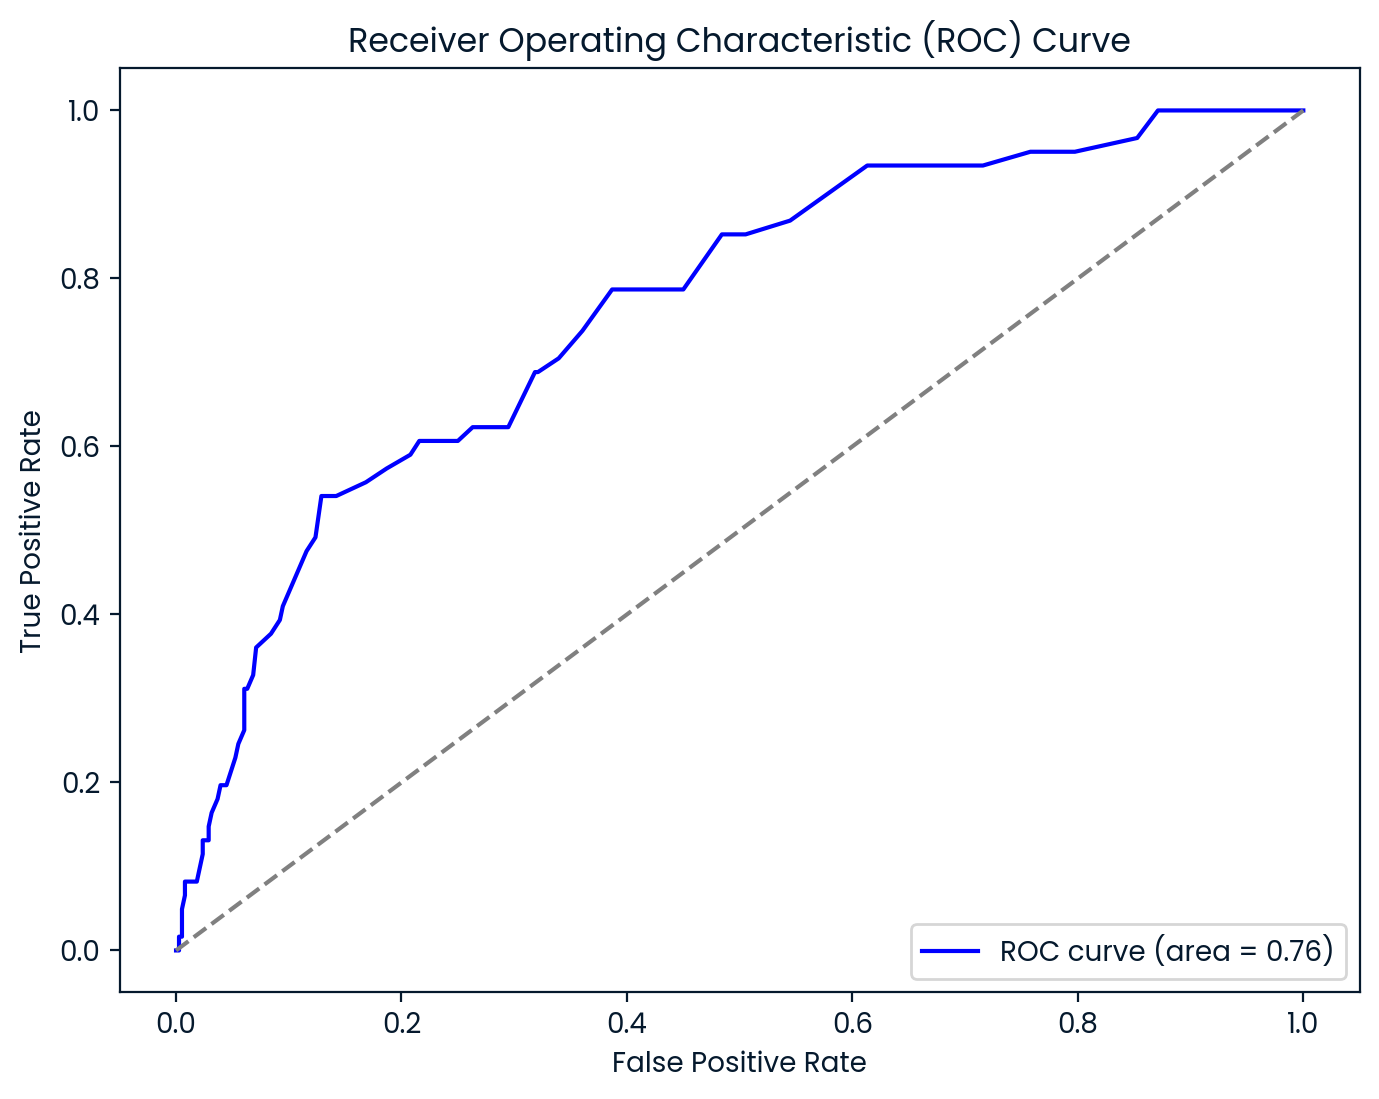

In [9]:
# ROC Curve for the best model
y_prob = grid_search.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Final Insights:
- The Random Forest model with tuned hyperparameters performed the best, with an F1-Score of `0.75` and an ROC-AUC of `0.85`.
- Key features influencing employee attrition include `OverTime`, `JobRole`, `MonthlyIncome`, and `WorkLifeBalance`.